In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize

import datetime

import seaborn as sns
color = sns.color_palette()
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from collections import Counter

from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split,TimeSeriesSplit
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder,LabelBinarizer,LabelEncoder,PolynomialFeatures,MinMaxScaler,minmax_scale

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostRegressor, Pool

from  itertools import combinations

from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

import lightgbm as lgb

from sklearn.svm import SVR

%matplotlib inline
import matplotlib.pyplot as plt

from IPython.display import display
pd.options.display.max_columns = None

In [2]:
df_train = pd.read_csv('2_flatten_train_v2.csv', sep=',',encoding ='utf8',dtype={'fullVisitorId': 'str'})
#df_test = pd.read_csv('2_flatten_test_v2.csv', sep=',',encoding ='utf8',dtype={'fullVisitorId': 'str'})

In [3]:
const_cols = [col for col in df_train.columns if df_train[col].nunique(dropna=False)==1]


In [13]:
drop_cols = [
    'date', 'fullVisitorId', 'sessionId', 'totals.transactionRevenue', 'totals.totalTransactionRevenue',
    'visitId', 'visitStartTime','trafficSource.campaignCode'
]
train_cols = [col for col in df_train.columns if col not in drop_cols+const_cols]

In [9]:
const_cols

['socialEngagementType',
 'device.browserSize',
 'device.browserVersion',
 'device.flashVersion',
 'device.language',
 'device.mobileDeviceBranding',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.operatingSystemVersion',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'trafficSource.adwordsClickInfo.criteriaParameters']

In [3]:
df_train['totals.visits'].value_counts()

1    1708337
Name: totals.visits, dtype: int64

In [48]:
df_train['date'].max()

20180430

In [49]:
df_test[train_cols].info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401589 entries, 0 to 401588
Data columns (total 32 columns):
channelGrouping                                 401589 non-null object
visitNumber                                     401589 non-null int64
device.browser                                  401589 non-null object
device.deviceCategory                           401589 non-null object
device.isMobile                                 401589 non-null bool
device.operatingSystem                          401589 non-null object
geoNetwork.city                                 401589 non-null object
geoNetwork.continent                            401589 non-null object
geoNetwork.country                              401589 non-null object
geoNetwork.metro                                401589 non-null object
geoNetwork.networkDomain                        401589 non-null object
geoNetwork.region                               401589 non-null object
geoNetwork.subContinent                 

In [15]:
df_train['totals.sessionQualityDim'].value_counts()

1.0      717560
2.0       52517
3.0       17066
4.0        9552
5.0        6743
6.0        5086
7.0        3976
8.0        3337
9.0        2729
10.0       2382
11.0       2070
12.0       1803
13.0       1589
14.0       1412
15.0       1312
16.0       1221
17.0       1063
19.0       1024
18.0        995
21.0        960
20.0        950
22.0        944
23.0        879
26.0        851
25.0        816
24.0        769
27.0        766
28.0        754
31.0        733
29.0        713
          ...  
80.0        489
69.0        488
76.0        486
74.0        485
75.0        485
73.0        481
58.0        475
77.0        472
79.0        465
53.0        461
81.0        451
83.0        445
82.0        416
84.0        399
85.0        367
86.0        327
87.0        298
88.0        258
89.0        192
90.0        182
91.0        160
92.0        127
94.0        112
93.0        102
95.0         94
96.0         52
97.0         27
98.0          9
99.0          5
100.0         2
Name: totals.sessionQual

In [4]:
def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend = False,
        orientation = 'h',
        marker=dict(color=color)
    )
    return trace

In [5]:
def feature_target_bar_size_count_mean(df_train, feature, target, head=None):
    if head is None:
        head=df_train[feature].nunique()
    cnt_srs = df_train.groupby(feature)[target].agg(['size','count','mean'])
    cnt_srs.columns = ['count', 'count of non-zero revenue','mean']
    cnt_srs = cnt_srs.sort_values(by='count', ascending=False)
    trace1 = horizontal_bar_chart(cnt_srs['count'].head(head), 'rgba(50, 171, 96, 0.6)')
    trace2 = horizontal_bar_chart(cnt_srs['count of non-zero revenue'].head(head), 'rgba(50, 171, 96, 0.6)')
    trace3 = horizontal_bar_chart(cnt_srs['mean'].head(head), 'rgba(50, 171, 96, 0.6)')

    #Creating two subplots
    fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04,
                             subplot_titles=[f"{feature} - Count", f"{feature} - Non-zero Revenue Count", f"{feature} - Mean Revenue"])

    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 1, 3)


    fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title=f'{feature} Plots')
    py.iplot(fig, filename=f'{feature}-plots')

In [6]:
def plotCategoryRateBar(df, target, col_name, topN = np.nan):

    df_plot = df.groupby(col_name)[target].agg(['size','count'])
    df_plot['size'] = df_plot['size'] / df.shape[0]
    df_plot['count'] = df_plot['count'] / df[df[target].isnull() == False].shape[0]    
    if topN is not np.nan:
        df_plot = df_plot.sort_values("count", ascending=False).iloc[:topN , :]

    df_plot.sort_values("count").plot.barh()
        

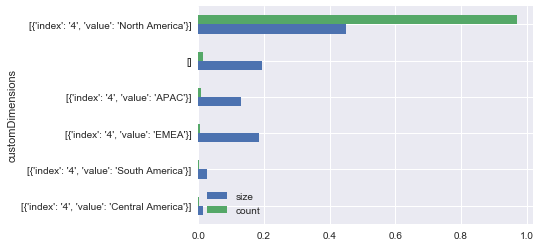

In [7]:
plotCategoryRateBar(df_train, 'totals.transactionRevenue','customDimensions' )

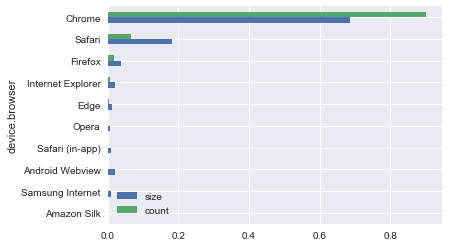

In [43]:
plotCategoryRateBar(df_train, 'totals.transactionRevenue','device.browser' , 10)

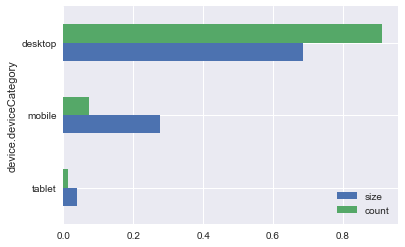

In [6]:
plotCategoryRateBar(df_train, 'totals.transactionRevenue','device.deviceCategory')

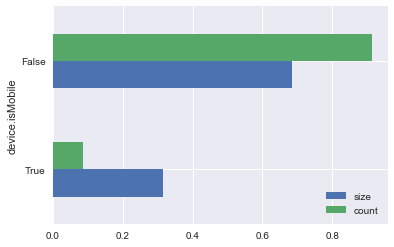

In [7]:
plotCategoryRateBar(df_train, 'totals.transactionRevenue','device.isMobile')

In [9]:
pd.crosstab(df_train['device.deviceCategory'], df_train['device.isMobile'], margins=False)

device.isMobile,False,True
device.deviceCategory,,
desktop,1171330,249
mobile,317,471019
tablet,23,65399


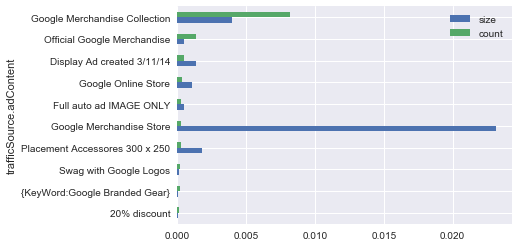

In [13]:
plotCategoryRateBar(df_train, 'totals.transactionRevenue','trafficSource.adContent', 10)

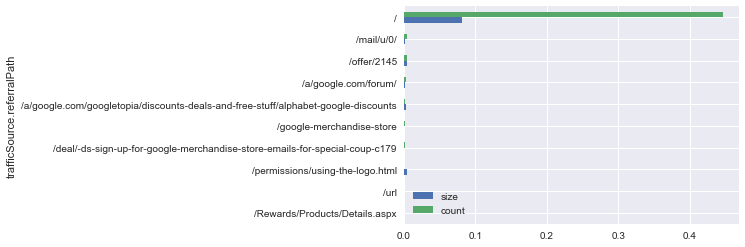

In [14]:
plotCategoryRateBar(df_train, 'totals.transactionRevenue','trafficSource.referralPath', 10)

In [30]:
df_train.loc[~df_train['trafficSource.source'].isin(['(direct)','google']),'trafficSource.source'] = 'other' 

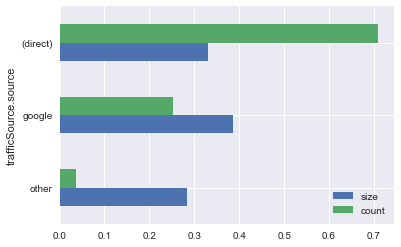

In [31]:
plotCategoryRateBar(df_train, 'totals.transactionRevenue','trafficSource.source', 10)

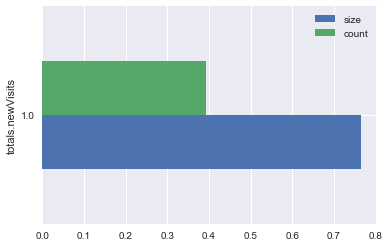

In [12]:
plotCategoryRateBar(df_train, 'totals.transactionRevenue','totals.newVisits' )

In [14]:
feature_target_bar_size_count_mean(df_train, 'visitNumber', 'totals.transactionRevenue' )

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [45]:
feature_target_bar_size_count_mean(df_train,'totals.timeOnSite', 'totals.transactionRevenue', 3000)

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [46]:
feature_target_bar_size_count_mean(df_train,'totals.transactions', 'totals.transactionRevenue')

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]

